### This script is used to vary the single event threshold. I.e.  E > E<sub>thresh</sub> for all events which compose coincident event

In [1]:
import numpy as np
from matplotlib.pyplot import *;import seaborn as sns
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
from numba import jit


def calibrate(data):
    for cal in pd.calibration:                      #THIS NEEDS TO BE IN PREDEFINED.py
        bd,ch=cal.board,cal.channel
        t=(data['board']==bd)*(data['channel']==ch)
        data['energy'][t]=(data['energy'][t]-cal.offset)/cal.slope
    return

@jit(nopython=True)
def multipixel_energies(energies,timestamps,t_coincident=250.):

    summed_energy=np.zeros_like(energies)
    length=len(energies)
    i=0 
    while i<length-2: 
        summed_energy[i]=energies[i]
        j=i+1
        coincident_event=(timestamps[j]-timestamps[i] < t_coincident) 
        while coincident_event and j<length-1:
            summed_energy[i]+=energies[j]
            j+=1 
            coincident_event=(timestamps[j]-timestamps[i] < t_coincident)
        i=j
    return summed_energy

@jit(nopython=True)
def coincident_pixel_energies(energies,timestamps,boards,channels,t_coincident=250.):
    summed_energy=np.zeros_like(energies)
    length=len(energies)
    i=0
    
    while i<length-3: 
        bd,ch=boards[i],channels[i]
        j=i+1
        IsthisPixel1=(bd,ch)==(1,3) #This could actually be a nice class. pixel=Pixel_object(bd,ch)
        IsthisPixel2=(bd,ch)==(4,3) #    then pixel.coincident returns the opposite pixel...
        if IsthisPixel1:            # I'm trying to determine if the j'th entry is a coincident pixel
            coincidentPixel=((4,3)==(boards[j],channels[j]))
        elif IsthisPixel2:
            coincidentPixel=((1,3)==(boards[j],channels[j]))
        else:
            i+=1
            continue
        coincidentTime=(timestamps[j]-timestamps[i]) < t_coincident  #Makes sure that the timestamps are close
        nonCoincidentThirdEvent=(timestamps[j+1]-timestamps[i])>t_coincident #Makes sure the i+2'th event is NOT a coincident event
        if coincidentPixel and coincidentTime and nonCoincidentThirdEvent:
            summed_energy[i]=energies[i]+energies[i+1]
        i=j+1
#
#    FOR NOW JUST LOOKING AT SINGLE BOUNCES. 64W -> 64E | 64E-> 64W ; NO OTHER EVENTS CONSIDERED
#
#         while coincident_time and coincidentPixel and j<length-1:
#             summed_energy[i]+=energies[j]
#             j+=1 
#             coincident_event=(timestamps[j]-timestamps[i] < t_coincident)
    return summed_energy



dummy=np.zeros(5)
multipixel_energies(dummy,dummy)
coincident_pixel_energies(dummy,dummy,dummy,dummy)
del dummy

In [25]:
path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/'
simpath='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'

#Loading in Simulation
simdata=np.load(simpath+'45Ca_b0.npy')
simdata=pd.sim_restructure(simdata)     #dtype=('entry', '<i4'), ('board', '<i4'), ('channel', '<i4'), ('timestamp', '<f4'), ('energy', '<f4')
simdata=simdata.view(np.recarray)          # simulation structure similar to data now
simdata.timestamp=pd.sim_realistic_timestamps(simdata.timestamp)
#####

runs=[run for run in os.listdir(path) if run.endswith('all.npy')]
runs.sort()
# runs=runs[0:2]
counts=0
beg=time.time()
Ecut=50
threshes= np.linspace(10,100,10)
with PdfPages('threshVar.pdf') as pdf:
    for Ecut in threshes:
        summed_energy=[]
        for run in runs:
            data=np.load(path+run)
            data.sort(order='timestamp')
            data=data.view(np.recarray)

            calibrate(data)
            t=data.energy>Ecut                                           #Energy Cut
            t=t*(data.t0>950)*(data.t0<1050)                           #t0
            t=t*(data.timestamp*4e-9/3600<1)                           #Removing bad timestamps

            summed_energy.append(coincident_pixel_energies(data.energy[t],
                                                           data.timestamp[t],
                                                           data.board[t],
                                                           data.channel[t],
                                                           t_coincident=1e2))
            counts+=len(data[t])
            print('\rfinished run '+run[4:-8]+' threshold= {threshold:d}keV in {time:0.2f} s'.format(threshold=int(Ecut),time=time.time()-beg),end='')
            sys.stdout.flush()
        summed_energy=np.concatenate(summed_energy)

        ## Applying cuts to simulation
        t=((simdata.board==2)+(simdata.board==5))*(simdata.channel==1)     #Removes knowledge of events on 77W/E
        t=np.logical_not(t)
        t*=simdata.energy>Ecut      #Energy cut


        sim_summed_energy=[]
        sim_summed_energy.append(coincident_pixel_energies(simdata.energy[t],
                                                       simdata.timestamp[t],
                                                       simdata.board[t],
                                                       simdata.channel[t],
                                                       t_coincident=1e2))

        fig,ax=subplots(figsize=(15,10))

        dataHist,b=np.histogram(summed_energy,bins=1000,
                      range=[0,800])   #Histogramming data
        b=pd.cbins(b)
        norm=np.sum(dataHist[b>150])
        ax.plot(b,dataHist,ds='steps',label='Data')



        h=np.histogram(sim_summed_energy,bins=1000,
                      range=[0,800])[0]   #Histogramming simulation
        norm/=np.sum(h[b>150])
        ax.plot(b,h*norm,ds='steps',label='Simulation')
        scale=max(h[b>10])
        ax.set_xlim(0,300)
        ax.set_ylim(1,scale*norm+0.1*scale*norm)
        ax.legend(fontsize=fs)
        ax.tick_params(labelsize=fs)
        ax.set_xlabel('Energy [keV]',fontsize=fs)
        ax.set_ylabel('Counts',fontsize=fs)
        ax.set_title('Coincident Spectrum: {threshold:d} keV Threshold'.format(threshold=int(Ecut)),fontsize=fs)
        
        ax=ax.twinx()
        t=dataHist!=0
        residuals=dataHist-h*norm
        chiSq=np.sum(residuals[t]**2./dataHist[t])/len(b[t])
        ax.plot((0,300),(0,0),'r--',lw=1)
        ax.plot(b[t],residuals[t]/dataHist[t],'ro',ms=2)
        ax.set_ylim(-2,2)
        ax.tick_params('y',labelsize=fs,colors='r')
        ax.set_ylabel('Fractional Residual',rotation=270, fontsize=fs, labelpad=10,color='r')
#         ax.text(0.9,0.7,'{chiSq:0.2f}'.format(chiSq=chiSq),transform=ax.transAxes)
        
        
        pdf.savefig()
        close()
print('\n done')

finished run 79 threshold= 100keV in 3061.16 ss
 done


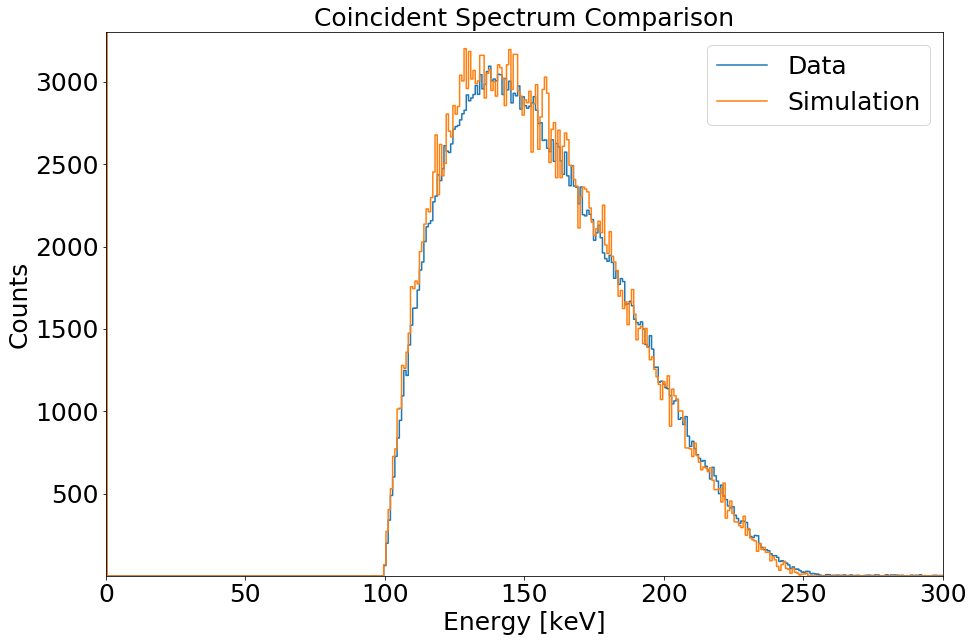

In [36]:

fig,ax=subplots(figsize=(15,10))

h,b=np.histogram(summed_energy,bins=1000,
              range=[0,800])   #Histogramming data
b=pd.cbins(b)
norm=np.sum(h[b>150])
ax.plot(b,h,ds='steps',label='Data')



h=np.histogram(sim_summed_energy,bins=1000,
              range=[0,800])[0]   #Histogramming simulation
norm/=np.sum(h[b>150])
ax.plot(b,h*norm,ds='steps',label='Simulation')
scale=max(h[b>10])

ax.set_xlim(0,300)
ax.set_ylim(1,scale*norm+100)
ax.legend(fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.set_ylabel('Counts',fontsize=fs)
ax.set_title('Coincident Spectrum Comparison',fontsize=fs)
# ax.set_yscale('log')

show()
